# Abell 1656: the Coma Cluster of Galaxies
This notebook is based on the EURO-VO tutorial: "Abell 1656: The Coma Cluster of Galaxies" (http://www.euro-vo.org/?q=science/scientific-tutorials) and shows how to perform steps 1 to 8 from within a Jupyter notebook. Steps 9 to 11 are not yet implemented. 

## Introduction
The goals of this notebook tutorial are:
 - Examine the Coma cluster of galaxies (Abell 1656) using services and data from the virtual observatory withinin a jupyter notebook in order to perform a quick evaluation of the mean redshift and velocity dispersion of the cluster. Both measurements are important to study the evolution of galaxy clusters. 
 - Use redshifts and photometry (Petrosian r magnitude) of the SDSS survey and then add redshifts of the CAIRNS survey (Rines et al. 2003) in order to improve the completeness of the redshift sample.
 
For our analysis we need to following python packages:

In [3]:
import ipyaladin.aladin_widget as ipyal
from astroquery.vizier import Vizier
from astroquery.xmatch import XMatch
from astropy.table import Table, vstack
from astropy import units as u
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np

In [2]:
%ipyal inline

UsageError: Line magic function `%ipyal` not found.


## Display the region of Abell 1656 in Aladin lite
We start by displaying the Coma Cluster in an Aladin Lite widget. We will centre the DSS2 colour images (`survey='P/DSS2/color'`) on Abell 1656 (`target='A1656'`) and set the field of view to 0.7deg (`fov=0.7`). At the distance of Coma, our field of view corresponds to approximately 1Mpc a region large enough for our purposes. 

Note that if you are using Jupyter lab you can now open a second python3 notebook, click on the "Python 3" button in the top, right corner of this notebook to switch kernel. A new window will pop up and you can then select this notebook (i.e. "Abel1656...") as kernel. This will link the two notebooks such that they see the same variables ect. You may use the second linked notebook to be able to look at a Aladin Lite widget the entire time, while doing the analysis work in this notebook. Please see the ipyaladin webpage for more information on how to use the widget in Jupyter lab. 

In [4]:
aladin = ipyal.Aladin(target='A1656', fov=0.7, survey='P/DSS2/color')

In [5]:
aladin

Aladin(fov=0.7, options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen', 'log', 'overlay_survey', 'ov…

As with any Aladin Lite implementation, you can interact with this widget: 
 - to zoom in and out place you mouse pointer on top of the image and scroll. 
 - with <img src="Images/ipyaladin_layer.png" alt="the Layer Button" style="width:30px; display: inline-block;"/>  you can select other image surveys and manage the current view.
 - if you like to look at another target, you can use the search field <img src="Images/ipyaladin_search.png" alt="the Search Button" style="width:30px; display: inline-block;"/> to get there. 

These interactions can also be steered by changing properties of the variable `aladin`. If for example, after zooming in and out, you wanted to set the FoV again to 0.7deg, do:

In [6]:
aladin.fov = 0.7

## Load the SDSS-DR9 catalog and select galaxies
In this section, we will search the SDSS DR9 catalogue at the VizieR catalogue service and then download all entries that are located within 40arcmin of the centre of the A1656. We start by querying VizieR for all catalogues that match the search term `SDSS DR9`: 

In [7]:
catalog_list = Vizier.find_catalogs('SDSS DR9')
print({k:v.description for k,v in catalog_list.items()})

{'II/336': 'AAVSO Photometric All Sky Survey (APASS) DR9 (Henden+, 2016)', 'V/139': 'The SDSS Photometric Catalog, Release 9 (Adelman-McCarthy+, 2012)', 'IX/48': 'Allsky cross-matched 3XMMe catalogue (Motch+, 2016)', 'J/A+A/547/L1': 'SDSS-III DR9 DLA catalogue (Noterdaeme+, 2012)', 'J/A+A/598/A92': 'New ultracool subdwarfs (Lodieu+, 2017)', 'J/MNRAS/444/2456': 'Spectral galaxy pairs from SDSS DR9 (Yang+, 2014)', 'J/MNRAS/445/1331': 'White-dwarf + main-sequence binaries in SDSS DR9 (Li+, 2014)', 'J/MNRAS/450/905': 'New SNe in SDSS DR9 (Graur+, 2015)', 'J/MNRAS/458/3808': 'DR9-12 SDSS WDMS binaries (Rebassa-Mansergas+, 2016)', 'J/other/NewA/58.61': 'SDSS DR9 galaxy clusters optical catalog (Banerjee+, 2018)', 'J/other/RAA/17.62': 'Candidate members of 4 stellar streams (Li+, 2017)'}


We want data from the main SDSS DR9 photometric catalogues: "The SDSS Photometric Catalog, Release 9 (Adelman-McCarthy+, 2012)". To do so we increase the limit of loaded rows from 50 (default set-up) to as many as there are and query the catalogue within 40arcmin of the cluster centre. 

In [8]:
Vizier.ROW_LIMIT = -1
results1 = Vizier.query_region("A1656", radius="0d40m0s", catalog='V/139')
print(results1)

TableList with 1 tables:
	'0:V/139/sdss9' with 21 column(s) and 37390 row(s) 


As you can see the result of our query includes data from one catalogue for 37390 objects (i.e. the table has 37390 rows). The output from this query is a list of astropy.table.table.Table objects. We now select the 0th table in this list, restrict the table to objects, which are galaxies ('cl' = 3) and also SDSS primary sources ('mode' = 1) (first line), and use only the columns named 'RA_ICRS', 'DE_ICRS', 'rmag' and 'zsp' (second line). 

In [9]:
sdss_dr9 = results1[0][(results1[0]['cl']==3) & (results1[0]['mode']==1)]
sdss_dr9 = sdss_dr9['RA_ICRS', 'DE_ICRS', 'rmag', 'zsp']
sdss_dr9

RA_ICRS,DE_ICRS,rmag,zsp
deg,deg,mag,
float64,float64,float32,float64
194.569924,28.086985,22.478,--
194.570071,28.183590,22.929,--
194.570196,28.192751,20.766,--
194.570584,28.218809,22.314,--
194.570635,28.014748,22.166,--
194.571112,28.082954,20.126,--
194.571272,28.156997,23.555,--
194.571287,28.157763,22.653,--


## Identify the brightest sources as being stars contaminating the sample
Since we are only interested in galaxies of the Abell 1656 cluster, we exclude stars from our sample. To do so we select the brightest sources ('rmag' < 11.5) and check with the Aladin lite widget that we actually only exclude stars. 

In [10]:
stars = sdss_dr9[sdss_dr9['rmag'] < 11.5]
aladin.add_table(stars)
print('Our sample contains {} stars.'.format(len(stars)))

Our sample contains 11 stars.


With the line `aladin.add_table(stars)`, we have added symbols to the Aladin Lite widget at the location of the brightest sources (i.e. stars). If you now scroll back up to the Aladin Lite widget and zoom out, you will be able to find all the brightest sources. By looking at each source (zoom in on them), you will find that these are indeed stars. 

## Build a subset of galaxies with photometry and redshift in SDSS
Now on to exploring the galaxies in our sample. 
We again build a subset, this time for all sources fainter than 11.5mag (to leave out the stars identified in the section above) but brighter than 17.77mag, which is the completeness limit the SDSS spectroscopic sample. 

In [11]:
zsp17 = sdss_dr9[(sdss_dr9['rmag'] > 11.5) & (sdss_dr9['rmag'] < 17.77)]
zsp17

RA_ICRS,DE_ICRS,rmag,zsp
deg,deg,mag,
float64,float64,float32,float64
194.572522,28.040079,16.927,0.02065
194.575458,28.070532,17.258,0.15735
194.582202,28.094842,17.195,0.02392
194.590439,28.148753,14.516,0.02628
194.590959,27.967780,14.059,0.02005
194.592319,28.152134,15.193,0.02227
194.606369,28.128924,15.663,0.02736
194.625853,28.014753,13.784,0.02384


## Improve the completeness with other sources of redshifts in Vizier
As you can see in the table above, not all galaxies in our zsp17 sample have redshift measurements (some rows have '--' in the 'zsp' column, i.e. they are masked). So in order to improve the completeness of our sample we will now use Vizier to search for redshifts in the Rines et al (2003) catalogue. First find all catalogues that match the search terms 'redshifts Rines 2003':

In [12]:
catalog_list = Vizier.find_catalogs('redshifts Rines 2003')
print({k:v.description for k,v in catalog_list.items()})

{'J/AJ/124/1266': 'Redshift survey around Abell 2199 (Rines+, 2002)', 'J/AJ/126/2152': 'Cluster And Infall Region Nearby Survey. I (Rines+, 2003)'}


Of these two catalogues, we are interested in the 'J/AJ/126/2152' catalogue, more specifically in their 'galaxies' subtable. So after dividing the zsp17 into two subsamples (the ones with zsp measurements - zsp17_with - and the ones without zsp measurements - zsp17_wihtout), we will use the `astroquery.XMatch.query` module to look for crossmatches of galaxies from the zsp17_wihtout sample in the 'J/AJ/126/2152/galaxies' hosted at Vizier.

In [13]:
ind = (zsp17['zsp'] < 5.) & (zsp17['zsp'] > 0.) # measured redshifts are between 0. and 2.
zsp17_with = zsp17[ind]
zsp17_without = zsp17[~ind]
zsp17_without.write('zsp17_without.csv')
table = XMatch.query(cat1=open('zsp17_without.csv'), 
                     cat2='vizier:J/AJ/126/2152/galaxies',
                     max_distance=5 * u.arcsec, colRA1='RA_ICRS',
                     colDec1='DE_ICRS')
table

/usr/local/lib/python3.6/dist-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/usr/local/lib/python3.6/dist-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


angDist,RA_ICRS,DE_ICRS,rmag,zsp,_RAJ2000,_DEJ2000,RAJ2000,DEJ2000,cz,e_cz,r_cz,Cluster
float64,float64,float64,float64,int64,float64,float64,str11,str11,int64,int64,int64,str5
2.355166,194.804612,27.976975,15.824,--,194.80417,27.9775,12 59 13.00,+27 58 39.0,6747,64,1,A1656
4.511264,194.869572,28.085778,16.586,--,194.86833,28.08517,12 59 28.40,+28 05 06.6,3650,100,2,A1656
2.499691,194.91736,28.179347,17.323,--,194.91658,28.17925,12 59 39.98,+28 10 45.3,5437,--,2,A1656
0.642092,195.044832,27.990943,14.771,--,195.04475,27.99078,13 00 10.74,+27 59 26.8,23078,41,2,A1656
0.854695,195.082099,28.121521,17.696,--,195.08183,28.12153,13 00 19.64,+28 07 17.5,6659,65,2,A1656
0.549166,194.629479,27.895503,17.676,--,194.62933,27.89558,12 58 31.04,+27 53 44.1,6804,83,2,A1656
1.36229,194.7349,27.803568,17.533,--,194.73492,27.80319,12 58 56.38,+27 48 11.5,7864,64,2,A1656
2.658001,194.847414,27.911604,13.451,--,194.84667,27.91194,12 59 23.20,+27 54 43.0,6899,31,1,A1656
0.283759,194.860237,27.856882,17.548,--,194.86017,27.85683,12 59 26.44,+27 51 24.6,5007,75,2,A1656


## Build the final catalogue including the Rines et al. (2003) redshifts
The resulting table of the cross-match above contains 27 rows, so we have found recession velocity ('cz') measurements for 27 galaxies. Now let's add these data to the zsp17_with table.

In [14]:
zsp17_with['cz'] = zsp17_with['zsp'] * 300000
zsp17_without = table[zsp17_with.colnames]
zsp17_final = vstack([zsp17_with, zsp17_without])
zsp17_final

RA_ICRS,DE_ICRS,rmag,zsp,cz
deg,deg,mag,,
float64,float64,float64,float64,float64
194.572522,28.040079,16.927,0.02065,6195.00000
194.575458,28.070532,17.258,0.15735,47205.00000
194.582202,28.094842,17.195,0.02392,7176.00000
194.590439,28.148753,14.516,0.02628,7884.00000
194.590959,27.967780,14.059,0.02005,6015.00000
194.592319,28.152134,15.193,0.02227,6681.00000
194.606369,28.128924,15.663,0.02736,8208.00000
194.625853,28.014753,13.784,0.02384,7152.00000


## Determine the cz distribution, the cluster average velocity and velocity dispersion
Based on the 511 galaxies, for which we now have measurements of their recession velocities, we can now analyse the recession velocity and velocity dispersion of the Abell 1656 galaxy cluster. First we visualise the entire sample:

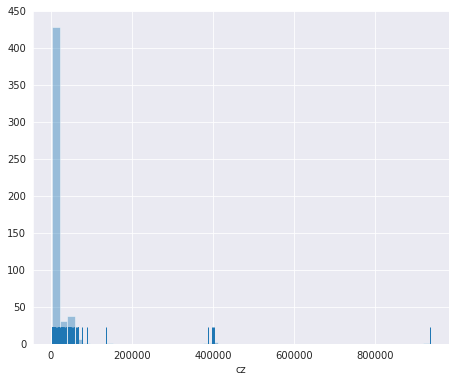

In [15]:
sns.set_style("darkgrid")
fig = plt.figure(figsize=(7.5, 6.0))
ax = fig.add_axes([0.17, 0.17, 0.77, 0.77])
sns.distplot(zsp17_final['cz'], rug=True, ax=ax, kde=False)

Note how there is a large range of recession velocities in our sample. We are only interested in the range of recession velocities of the Coma cluster. These are included in the peak at low velocities. To focus on these, we restrict ourselves to recession velocities between 3000 and 11000 km/s. For easy analysis we first create the subsample `zsp17_coma` and then visualise the distribution of the recession velocity in this subsample:

(3000, 11000)

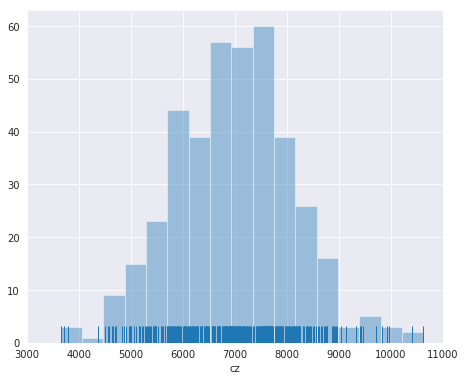

In [16]:
ind = (zsp17_final['cz'] > 3000.) & (zsp17_final['cz'] < 11000.)
zsp17_coma = zsp17_final[ind]

sns.set_style("darkgrid")
fig = plt.figure(figsize=(7.5, 6.0))
ax = fig.add_axes([0.17, 0.17, 0.77, 0.77])
sns.distplot(zsp17_coma['cz'], rug=True, ax=ax, kde=False)
ax.set_xlim([3000, 11000])

These are data of all galaxies for which we collected redshift/recession velocity measurements and which are in the vincinity of the cluster (both spatially and in recession velocity). Now let's calculate the mean recession velocity of the cluster and its velocity dispersion:

In [17]:
print('The mean velocity in Coma is: {0:.1f}km/s and \
the standard deviation (i.e. velocity dispersion):\
{1:.1f}km/s'.format(np.mean(zsp17_coma['cz']), np.std(zsp17_coma['cz'])))

The mean velocity in Coma is: 6978.4km/s and the standard deviation (i.e. velocity dispersion):1138.9km/s


This is in agreement with more refined analyses (see for example Sohn et al. 2017, ApJS, 229, 20). 